In [ ]:
####### Import Necessary Libraries #######
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
from typing import Optional, Dict, Any, List, Tuple
from tqdm.auto import tqdm
import random


####### Data Loading && Preparation #######
import nltk
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import SequenceClassifierOutput
# Use This for HF Dataset
from datasets import Dataset, DatasetDict

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datetime import datetime

####### Modelling #######
import torch
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


#######Evaluation & Result #######
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, precision_recall_fscore_support
import itertools


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KOMPUTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# Logging (To save Many Many Many Experiment)

In [ ]:
def save_experiment_log(
    decoded_labels,
    decoded_preds,
    splits: dict,
    total_samples: int,
    model_name: str,
    model_params: dict | None = None,
    extra_info: dict | None = None,
    log_path: str = "experiment_log.csv",
    experiment_name: str | None = None
):
    """
    Percentage-based experiment logger.

    splits example:
    {
        "train": 0.8,
        "val": 0.1,
        "test": 0.2,
        "fold": 5
    }
    """

    report = classification_report(
        decoded_labels,
        decoded_preds,
        output_dict=True
    )

    row = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": experiment_name or f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "model": model_name,
        "total_samples": total_samples,

        # === METRICS ===
        "accuracy": round(report["accuracy"], 2),

        "precision_macro": round(report["macro avg"]["precision"], 2),
        "recall_macro": round(report["macro avg"]["recall"], 2),
        "f1_macro": round(report["macro avg"]["f1-score"], 2),

        "precision_weighted": round(report["weighted avg"]["precision"], 2),
        "recall_weighted": round(report["weighted avg"]["recall"], 2),
        "f1_weighted": round(report["weighted avg"]["f1-score"], 2),
    }

    # === SPLITS (PERCENTAGE) ===
    for k, v in splits.items():
        if k == "fold":
            row["cv_folds"] = v
        else:
            row[f"{k}_ratio"] = v
            row[f"{k}_pct"] = round(v * 100, 2)

    # === MODEL PARAMS ===
    if model_params:
        for k, v in model_params.items():
            row[f"param_{k}"] = v

    # === EXTRA INFO ===
    if extra_info:
        for k, v in extra_info.items():
            row[f"info_{k}"] = v

    df_new = pd.DataFrame([row])

    if os.path.exists(log_path):
        df_old = pd.read_csv(log_path)
        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(log_path, index=False)
    print(f"✅ Experiment logged → {log_path}")


# Data Loading

In [ ]:
BLOOM_DATASET = '../../Dataset/learning_outcomes.csv'
PAIR_DATASET = '../../Dataset/cpmk_subcpmk_pairs.csv'

In [ ]:
bloom_df = pd.read_csv(BLOOM_DATASET)
pair_df = pd.read_csv(PAIR_DATASET)

print(bloom_df)
pair_df

                                       Learning_Outcome     Jenis Level
0     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
1     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
2     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
3                           Mampu merancang gardu induk      CPMK    C6
4                           Mampu merancang gardu induk      CPMK    C6
...                                                 ...       ...   ...
2571  Mahasiswa dapat memahami dan mempraktekkan iba...  Sub-CPMK    P3
2572  Mampu menunjukan pelaksanaan penegakan hukum &...  Sub-CPMK    A5
2573  Mahasiswa mampu menunjukkan implementasi nilai...  Sub-CPMK    A5
2574  Mampu bertindak mengimplementasikan makna Sila...  Sub-CPMK    A5
2575  Mampu bertindak mengimplementasikan Sila Ke-4 ...  Sub-CPMK    A5

[2576 rows x 3 columns]


,cpmk,level_cpmk,subcpmk,level_subcpmk,keselarasan
0,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Merencanakan aplikasi menggunakan prinsip dasa...,C6,True
1,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Menyelesaikan logic functions and gates,C2,True
2,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Mengevaluasi boolean algebra dan combinational...,C5,True
3,Mampu merancang gardu induk,C6,Mampu merancang instalasi listrik gardu induk,C6,True
4,Mampu merancang gardu induk,C6,Mampu merancang sistem pengetanahan gardu induk,C6,True
...,...,...,...,...,...
1283,"Mahasiswa mampu mempraktekkan haji, umroh dan ...",P3,Mahasiswa dapat memahami dan mempraktekkan iba...,P3,True
1284,"Mampu menganalisis masalah kontekstual PKn, me...",C4,Mampu menunjukan pelaksanaan penegakan hukum &...,A5,False
1285,Mahasiswa mampu menafsirkan dan menerapkan nil...,C3,Mahasiswa mampu menunjukkan implementasi nilai...,A5,False
1286,"Mampu menunjukan nilai ketuhanan, nilai kemanu...",A5,Mampu bertindak mengimplementasikan makna Sila...,A5,True


# Data Preparation & Modelling - Bloom

## Data Preparation

In [ ]:
# Basic checks & cleaning
required_cols = ["Learning_Outcome", "Level"]
if not all(c in bloom_df.columns for c in required_cols):
    raise ValueError(f"CSV must contain columns: {required_cols}. Found: {list(bloom_df.columns)}")

bloom_df = bloom_df.dropna(subset=["Learning_Outcome", "Level"]).reset_index(drop=True)
bloom_df["Learning_Outcome"] = bloom_df["Learning_Outcome"].astype(str).str.strip()
bloom_df["Level"] = bloom_df["Level"].astype(str).str.strip().str.upper()

In [ ]:
# Create label mapping
labels = sorted(bloom_df["Level"].unique().tolist(), key=lambda x: (x[0], int(x[1:]) if x[1:].isdigit() else x))
label2id = {lab:i for i, lab in enumerate(labels)}
id2label = {i:lab for lab,i in label2id.items()}

bloom_df["label_id"] = bloom_df["Level"].map(label2id)

In [ ]:
# Train / val split (stratify by label)
train_df, val_df = train_test_split(bloom_df, test_size=0.2, random_state=42, stratify=bloom_df["label_id"])
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
datasets = DatasetDict({"train": train_ds, "validation": val_ds})


## Modelling

### Preparation

In [ ]:
INDO_BERT_BASE = "indobenchmark/indobert-base-p2"


In [ ]:
OUTPUT_DIR = "Classification-result/indobert_base_single_head_out_optimized"
SEED = 42
BATCH_SIZE = 16
EPOCHS = 7
LR = 2e-5
MAX_LEN = 512

In [ ]:
MODEL_NAME = INDO_BERT_BASE
# Tokenizer and preprocessing
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [ ]:

# Model
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(INDO_BERT_BASE , num_labels=num_labels, use_safetensors=True)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Zero-Shot Learning

In [ ]:
bloom_ds = Dataset.from_pandas(
    bloom_df.reset_index(drop=True)
)

bloom_ds = bloom_ds.map(
    preprocess_fn,
    batched=True,
    remove_columns=bloom_ds.column_names
)

bloom_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [ ]:
loader = DataLoader(
    bloom_ds,
    batch_size=16,
    shuffle=False
)

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader, desc="Evaluating IndoBERT (no_grad)"):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device),
        }
        labels = batch["labels"].to(model.device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Evaluating IndoBERT (no_grad):   0%|          | 0/161 [00:00<?, ?it/s]

In [ ]:
decoded_preds = [id2label[int(i)] for i in all_preds]
decoded_labels = [id2label[int(i)] for i in all_labels]

print(classification_report(decoded_labels, decoded_preds))

              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         3
          A3       0.00      0.00      0.00         5
          A4       0.00      0.00      0.00        78
          A5       0.00      0.00      0.00        77
          C1       0.03      0.95      0.06        87
          C2       0.17      0.00      0.00       491
          C3       0.00      0.00      0.00       292
          C4       0.00      0.00      0.00       488
          C5       0.00      0.00      0.00       211
          C6       0.00      0.00      0.00       466
          P2       0.00      0.00      0.00        29
          P3       0.00      0.00      0.00       224
          P4       0.00      0.00      0.00       103
          P5       0.00      0.00      0.00        22

    accuracy                           0.03      2576
   macro avg       0.01      0.07      0.00      2576
weighted avg       0.03      0.03      0.00      2576



C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

### Single Head

#### Fine-Tune

In [ ]:

def preprocess_fn(batch):
    enc = tokenizer(batch["Learning_Outcome"], truncation=True, padding="max_length", max_length=MAX_LEN)
    enc["labels"] = batch["label_id"]
    return enc

datasets = datasets.map(preprocess_fn, batched=True, remove_columns=datasets["train"].column_names)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/2060 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    preds_logits, labels = eval_pred
    preds = np.argmax(preds_logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


In [ ]:

# Training args
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_strategy="epoch",
    weight_decay=0.01,
    logging_steps=50,
    seed=SEED,
    fp16= True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)



In [ ]:
import accelerate
print(accelerate.__version__)
print(accelerate.__file__)

1.12.0
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\accelerate\__init__.py


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\KOMPUTER\AppData\Local\Temp\ipykernel_16820\1674331945.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.204600,0.866714,0.755814,0.728599,0.755814,0.724074
2,0.669300,0.714716,0.800388,0.779904,0.800388,0.782559
3,0.439700,0.649263,0.812016,0.801436,0.812016,0.798176
4,0.284800,0.661435,0.821705,0.804020,0.821705,0.807283
5,0.183600,0.657002,0.835271,0.823532,0.835271,0.827101
6,0.125500,0.671311,0.833333,0.823526,0.833333,0.824200
7,0.088800,0.671729,0.837209,0.825275,0.837209,0.828501


TrainOutput(global_step=903, training_loss=0.46852279044398965, metrics={'train_runtime': 476.8553, 'train_samples_per_second': 30.24, 'train_steps_per_second': 1.894, 'total_flos': 3794470202449920.0, 'train_loss': 0.46852279044398965, 'epoch': 7.0})

In [ ]:
import os

# Eval final
metrics = trainer.evaluate()
print("Final evaluation metrics:", metrics)

Final evaluation metrics: {'eval_loss': 0.6717288494110107, 'eval_accuracy': 0.8372093023255814, 'eval_precision': 0.8252750702936101, 'eval_recall': 0.8372093023255814, 'eval_f1': 0.8285013266249108, 'eval_runtime': 4.3389, 'eval_samples_per_second': 118.925, 'eval_steps_per_second': 7.606, 'epoch': 7.0}


#### Eval-Bloom Accuracy

In [ ]:
def preprocess(ex):
    return tokenizer(
        ex["Learning_Outcome"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

val_tokenized = val_ds.map(preprocess, batched=True)
val_tokenized = val_tokenized.rename_column("label_id", "labels")

from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "input_ids": torch.tensor([x["input_ids"] for x in batch]),
        "attention_mask": torch.tensor([x["attention_mask"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

loader = DataLoader(val_tokenized, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device)
        }
        labels = batch["labels"].to(model.device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

decoded_preds = [id2label[i] for i in all_predictions]
decoded_labels = [id2label[i] for i in all_labels]


print(classification_report(decoded_labels, decoded_preds))



Map:   0%|          | 0/516 [00:00<?, ? examples/s]

  0%|          | 0/33 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         1
          A3       0.00      0.00      0.00         1
          A4       0.62      0.31      0.42        16
          A5       0.71      0.80      0.75        15
          C1       0.89      0.94      0.91        17
          C2       0.89      0.95      0.92        98
          C3       0.81      0.78      0.79        59
          C4       0.85      0.86      0.85        98
          C5       0.86      0.86      0.86        42
          C6       0.93      0.99      0.96        93
          P2       0.67      0.33      0.44         6
          P3       0.69      0.69      0.69        45
          P4       0.68      0.71      0.70        21
          P5       0.00      0.00      0.00         4

    accuracy                           0.84       516
   macro avg       0.61      0.59      0.59       516
weighted avg       0.83      0.84      0.83       516



C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

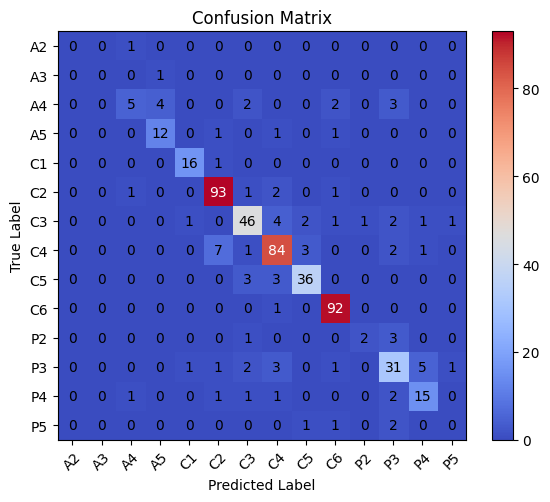

In [ ]:
labels = sorted(list(set(decoded_labels)))


cm = confusion_matrix(
    decoded_labels,
    decoded_preds,
    labels=labels
)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="coolwarm")
plt.colorbar()

plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

threshold = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()



In [ ]:
save_experiment_log(
    decoded_labels,
    decoded_preds,
    splits={"train": 0.8, "test": 0.2},
    model_name="IndoBERT",
    model_params={
        "max_len": MAX_LEN,
        "epochs": EPOCHS,
        "LR": LR,
        "BATCH_SIZE": BATCH_SIZE,
        "SEED": SEED
    },
    extra_info={
        "dataset": "full",
    },
    experiment_name="indobert_base_test_10_v1",
    total_samples = 2576

)


✅ Experiment logged → experiment_log.csv


C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [ ]:
# Save model, tokenizer, and label maps
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
pd.to_pickle(label2id, os.path.join(OUTPUT_DIR, "label2id.pkl"))
pd.to_pickle(id2label, os.path.join(OUTPUT_DIR, "id2label.pkl"))
print("Model & tokenizer saved to", OUTPUT_DIR)

Model & tokenizer saved to Classification-result/indobert_base_single_head_out_optimized


#### Eval-Alignment Accuracy

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification


MODEL_DIR = "Classification-result/indobert_base_single_head_out"   # tempat model & tokenizer disimpan
BATCH_SIZE = 16
MAX_LEN = 128
# nama kolom di dataframe
CPMK_COL = "cpmk"
SUBCPMK_COL = "subcpmk"
GOLD_KES_COL = "keselarasan"

In [ ]:
def predict_texts(texts, batch_size=BATCH_SIZE):
    preds = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_texts = [str(t) if t is not None else "" for t in texts[i:i+batch_size]]
        enc = tokenizer(batch_texts, padding="longest", truncation=True, max_length=MAX_LEN, return_tensors="pt")
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            preds.extend(batch_preds)
    return preds

def decode_ids_to_labels(id_list):
    return [id2label.get(int(i), "UNK") for i in id_list]


def pred_selaras_separated(row):
    dom_c, lvl_c = row["pred_domain_cpmk"], row["pred_level_cpmk"]
    dom_s, lvl_s = row["pred_domain_sub"], row["pred_level_sub"]
    # if any missing -> mark as Tidak Selaras (or choose None)
    if dom_c is None or dom_s is None or lvl_c is None or lvl_s is None:
        return "Tidak Selaras"
    # domain must match and CPMK level must be >= Sub level
    if dom_c != dom_s:
        return "Tidak Selaras"
    if lvl_c < lvl_s:
        return "Tidak Selaras"
    return "Selaras"

def pred_selaras(row):
    c = row["pred_label_cpmk"]
    s = row["pred_label_subcpmk"]

    # cek jika kosong atau bukan string
    if not isinstance(c, str) or not isinstance(s, str):
        return "False"

    # cek minimal panjang string
    if len(c) < 2 or len(s) < 2:
        return "False"

    # ambil domain dan level
    dom_c, lvl_c = c[0], c[1:]
    dom_s, lvl_s = s[0], s[1:]

    # pastikan level bisa di-convert ke int
    if not lvl_c.isdigit() or not lvl_s.isdigit():
        return "False"

    lvl_c = int(lvl_c)
    lvl_s = int(lvl_s)

    # domain harus sama
    if dom_c != dom_s:
        return "False"

    if lvl_c < lvl_s:
        return "False"

    return "True"


In [ ]:
from transformers import AutoModelForSequenceClassification
# load config + tokenizer
config = AutoConfig.from_pretrained(MODEL_DIR, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True,
    config=config
)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
df =pair_df

df[CPMK_COL] = df[CPMK_COL].fillna("").astype(str)
df[SUBCPMK_COL] = df[SUBCPMK_COL].fillna("").astype(str)

# predict label ids
pred_ids_cpmk = predict_texts(df[CPMK_COL].tolist(), batch_size=BATCH_SIZE)
pred_ids_sub = predict_texts(df[SUBCPMK_COL].tolist(), batch_size=BATCH_SIZE)

# decode to label strings
pred_labels_cpmk = decode_ids_to_labels(pred_ids_cpmk)
pred_labels_sub = decode_ids_to_labels(pred_ids_sub)



Predicting:   0%|          | 0/81 [00:00<?, ?it/s]

Predicting:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
df = df.copy()
df["pred_label_cpmk"] = pred_labels_cpmk
df["pred_label_subcpmk"] = pred_labels_sub


df["pred_keselarasan"] = df.apply(pred_selaras, axis=1)

In [ ]:
def plot_confusion_matrix(
    y_true,
    y_pred,
    labels,
    title="Confusion Matrix",
    normalize=False,
    cmap="coolwarm",
    figsize=(5, 4)
):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, cmap=cmap)
    plt.colorbar()

    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

    threshold = cm.max() / 2
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
            plt.text(
                j, i, text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > threshold else "black"
            )

    plt.tight_layout()
    plt.show()


Keselarasan evaluation:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93       410
        True       0.97      0.97      0.97       878

    accuracy                           0.95      1288
   macro avg       0.95      0.95      0.95      1288
weighted avg       0.96      0.95      0.95      1288

Accuracy: 0.9549689440993789


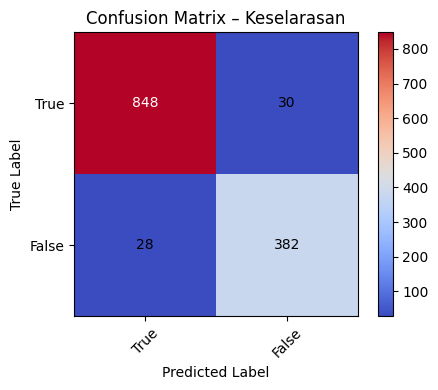

,cpmk,pred_label_cpmk,subcpmk,pred_label_subcpmk,pred_keselarasan
1120,Mahasiswa mampu mempraktikan dan analisis terh...,C4,Mahasiswa mampu mengidentifikasi profil tanah...,C1,True
1185,Mahasiswa mampu mempraktikkan proses rekrutmen...,P3,Mahasiswa melakukan evaluasi terhadap proses s...,C5,False
462,Mampu menyajikan serta mengolah data secara il...,C3,Mampu mengolah data secara ilmiah,C3,True
81,Mahasiswa mampu melakukan analisis gender dan ...,C4,Mahasiswa mampu menjelaskan langkah analisis p...,C2,True
63,Mahasiswa mampu menerapkan konsep dasar biosta...,C3,"mahasiswa mampu menyebutkan jenis-jenis data, ...",C1,True
123,Mahasiwa mampu memahami Analisis Spasial Mengg...,C2,Mahasiswa mampu menjelaskan aplikasi SatScan d...,C2,True
451,Mahasiswa mampu mendeskripsikan struktur dan s...,C2,Mahasiswa mampu mendeskripsikan struktur dan s...,C2,True
1042,Mahasiswa mampu menyusun identitas awal perusa...,C3,Mahasiswa mampu membuat nomor dan nama rekenin...,C3,True
723,Mahasiswa mampu menyelesaikan prosedur akuntan...,C3,Mahasiswa mampu menyelesaikan prosedur akuntan...,C3,True
44,Mahasiswa mampu memahami gagasan utama dari pe...,C2,Mampu memahami gagasan utama dan informasi det...,C4,False


In [ ]:
if "level_cpmk" in df.columns and "level_subcpmk" in df.columns:
        # convert true columns to same format as model (e.g. 'C3')
    true_labels_cpmk = df["level_cpmk"].astype(str).str.upper().tolist()
    true_labels_sub = df["level_subcpmk"].astype(str).str.upper().tolist()

if GOLD_KES_COL in df.columns:
    gold = df[GOLD_KES_COL].astype(str).str.strip().replace({"SELARAS":"Selaras","TIDAK SELARAS":"Tidak Selaras"})
    pred = df["pred_keselarasan"]
    print("Keselarasan evaluation:")
    print(classification_report(gold, pred, zero_division=0))
    print("Accuracy:", accuracy_score(gold, pred))

    plot_confusion_matrix(
        gold,
        pred,
        labels=["True", "False"],
        title="Confusion Matrix – Keselarasan",
        normalize=False
    )
else:
    print(f"No gold keselarasan column named '{GOLD_KES_COL}' found — created predictions only.")


display(df[[CPMK_COL, "pred_label_cpmk", SUBCPMK_COL, "pred_label_subcpmk", "pred_keselarasan"]].sample(10, random_state=42))

#### Save Model

### Double Head

#### Fine-Tune

In [ ]:
SEED = 42
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
OUTPUT_DIR = "Classification-result/indobert_double_head_out"

In [ ]:
bloom_df['Level']

0       C6
1       C6
2       C6
3       C6
4       C6
        ..
2571    P3
2572    A5
2573    A5
2574    A5
2575    A5
Name: Level, Length: 2576, dtype: object

In [ ]:
# Pecah CPMK menjadi data terpisah
bloom_df['Domain'] = bloom_df['Level'].str[0]
bloom_df['Aligned'] = bloom_df['Level'].str[1:].astype(int)


In [ ]:
# Create mappings for Domain and Level
domain_classes = sorted(bloom_df['Domain'].unique().tolist())
level_classes = sorted(bloom_df['Level'].unique().tolist(), key=lambda x: (x[0], int(x[1:]) if x[1:].isdigit() else x[1:]))

domain2id = {c:i for i,c in enumerate(domain_classes)}
id2domain = {i:c for c,i in domain2id.items()}

level2id = {c:i for i,c in enumerate(level_classes)}
id2level = {i:c for c,i in level2id.items()}

bloom_df['domain_label'] = bloom_df['Domain'].map(domain2id)
bloom_df['level_label'] = bloom_df['Level'].map(level2id)

# Train/val split
train_df, val_df = train_test_split(bloom_df, test_size=0.1, random_state=SEED, stratify=bloom_df['level_label'])
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(INDO_BERT_BASE)

def preprocess(batch):
    enc = tokenizer(batch["Learning_Outcome"], padding="max_length", truncation=True, max_length=MAX_LEN)
    # map labels dari kolom yang sebelumnya kamu punya: 'domain_label' dan 'level_label'
    enc["labels_domain"] = batch["domain_label"]
    enc["labels_level"]  = batch["level_label"]
    return enc

datasets = datasets.map(preprocess, batched=True)


Map:   0%|          | 0/2318 [00:00<?, ? examples/s]

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

In [ ]:
print("Columns after map:", datasets["train"].column_names)

Columns after map: ['Learning_Outcome', 'Jenis', 'Level', 'label_id', 'Domain', 'Aligned', 'domain_label', 'level_label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels_domain', 'labels_level']


In [ ]:
torch_cols = ["input_ids", "attention_mask", "labels_domain", "labels_level"]
datasets.set_format(type="torch", columns=torch_cols)

train_loader = DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(datasets["validation"], batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from transformers import PreTrainedModel, PretrainedConfig, AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch
import warnings

class MultiTaskConfig(PretrainedConfig):
    model_type = "indobert-multitask"
    def __init__(self, base_model_name_or_path=None, num_domain_labels=0, num_level_labels=0, **kwargs):
        super().__init__(**kwargs)
        self.base_model_name_or_path = base_model_name_or_path
        self.num_domain_labels = num_domain_labels
        self.num_level_labels = num_level_labels

class IndoBertForMultiTask(PreTrainedModel):
    config_class = MultiTaskConfig

    def __init__(self, config: MultiTaskConfig):
        super().__init__(config)
        # Use AutoModel (encoder only) so we reliably get last_hidden_state
        # If you have memory issues, consider using a 'base' or 'small' checkpoint.
        try:
            self.bert = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path , num_labels=num_labels, use_safetensors=True)
        except Exception as e:
            # fallback: try without output_hidden_states
            warnings.warn(f"AutoModel.from_pretrained failed with: {e}. Retrying without output_hidden_states.")
            self.bert = AutoModel.from_pretrained(config.base_model_name_or_path, use_safetensors=True)

        hidden_size = self.bert.config.hidden_size

        # two classifier heads
        self.classifier_domain = nn.Linear(hidden_size, config.num_domain_labels)
        self.classifier_level  = nn.Linear(hidden_size, config.num_level_labels)
        self.dropout = nn.Dropout(0.1)

        # initialize weights
        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels_domain=None, labels_level=None, return_dict=True, **kwargs):
        # encoder forward
        # allow token_type_ids to be None for models that don't use it
        bert_kwargs = {"input_ids": input_ids, "attention_mask": attention_mask}
        if token_type_ids is not None:
            bert_kwargs["token_type_ids"] = token_type_ids

        outputs = self.bert(**bert_kwargs, return_dict=True)

        # --- robust retrieval of pooled representation ---
        # Prefer pooler_output if provided
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled = outputs.pooler_output
        else:
            # try last_hidden_state
            last_hidden_state = None
            if hasattr(outputs, "last_hidden_state") and outputs.last_hidden_state is not None:
                last_hidden_state = outputs.last_hidden_state
            elif isinstance(outputs, tuple) and len(outputs) > 0:
                # many HF models return tuple where [0] is last_hidden_state
                last_hidden_state = outputs[0]
            elif hasattr(outputs, "hidden_states") and outputs.hidden_states and len(outputs.hidden_states) > 0:
                # use last entry of hidden_states
                last_hidden_state = outputs.hidden_states[-1]

            if last_hidden_state is None:
                raise ValueError(
                    "Cannot obtain last_hidden_state from encoder outputs. "
                    "Make sure you loaded an encoder model (AutoModel) not a SequenceClassification model, "
                    "or enable output_hidden_states in config."
                )
            pooled = last_hidden_state[:, 0, :]   # CLS token

        pooled = self.dropout(pooled)

        logits_domain = self.classifier_domain(pooled)
        logits_level  = self.classifier_level(pooled)

        loss = None
        if labels_domain is not None and labels_level is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_domain = loss_fct(logits_domain.view(-1, self.config.num_domain_labels), labels_domain.view(-1))
            loss_level  = loss_fct(logits_level.view(-1,  self.config.num_level_labels),  labels_level.view(-1))
            loss = loss_domain + loss_level

        # Build SequenceClassifierOutput (primary logits set to level logits)
        seq_out = SequenceClassifierOutput(
            loss=loss,
            logits=logits_level,   # primary logits so Trainer compatibility preserved
            hidden_states=getattr(outputs, "hidden_states", None),
            attentions=getattr(outputs, "attentions", None),
        )

        # return tuple (seq_out, logits_domain, logits_level) for compatibility with custom trainer
        return seq_out, logits_domain, logits_level


In [ ]:
# trainer.py
import os
import math
from typing import Optional, Dict, Any, List
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class MultiTaskTorchTrainer:
    """
    Trainer for multitask model with two heads (domain + level).
    Expects model.forward(...) to return (seq_out, logits_domain, logits_level)
    DataLoader must yield dicts containing:
      - input_ids, attention_mask, (optional token_type_ids)
      - labels_domain (torch.LongTensor), labels_level (torch.LongTensor)
    """
    def __init__(self,
                 model: torch.nn.Module,
                 train_loader,
                 val_loader=None,
                 device: Optional[torch.device]=None,
                 optimizer: Optional[torch.optim.Optimizer]=None,
                 scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]=None,
                 num_epochs: int = 3,
                 save_dir: str = "./model_out",
                 clip_grad_norm: Optional[float] = None,
                 loss_weights=(1.0, 1.0)):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.clip_grad_norm = clip_grad_norm
        self.loss_weights = loss_weights
        self.ce = nn.CrossEntropyLoss()

    def _extract_logits(self, outputs):
        # outputs expected (seq_out, logits_domain, logits_level)
        if isinstance(outputs, tuple) and len(outputs) >= 3:
            _, logits_domain, logits_level = outputs[:3]
            return logits_domain, logits_level
        if hasattr(outputs, "logits_domain") and hasattr(outputs, "logits_level"):
            return outputs.logits_domain, outputs.logits_level
        if isinstance(outputs, dict) and "logits_domain" in outputs and "logits_level" in outputs:
            return outputs["logits_domain"], outputs["logits_level"]
        # fallback: if single logits provided, use it for both (not recommended)
        if hasattr(outputs, "logits"):
            return outputs.logits, outputs.logits
        raise ValueError("Model output format not recognized. Expect tuple(seq_out, logits_domain, logits_level).")

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        # === TAMBAHAN: penampung metric ===
        preds_dom, preds_lvl = [], []
        labs_dom, labs_lvl   = [], []

        pbar = tqdm(self.train_loader, desc="Train", leave=False)
        for batch in pbar:
            batch = {k: (v.to(self.device) if isinstance(v, torch.Tensor) else v)
                    for k, v in batch.items()}

            labels_domain = batch.pop("labels_domain", None)
            labels_level  = batch.pop("labels_level", None)

            if labels_domain is None or labels_level is None:
                raise ValueError("Batch must include 'labels_domain' and 'labels_level'.")

            self.optimizer.zero_grad()

            outputs = self.model(**batch)
            logits_domain, logits_level = self._extract_logits(outputs)

            loss_domain = self.ce(
                logits_domain.view(-1, logits_domain.size(-1)),
                labels_domain.view(-1)
            )
            loss_level = self.ce(
                logits_level.view(-1, logits_level.size(-1)),
                labels_level.view(-1)
            )

            loss = (
                self.loss_weights[0] * loss_domain +
                self.loss_weights[1] * loss_level
            )

            loss.backward()

            if self.clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), self.clip_grad_norm
                )

            self.optimizer.step()

            if self.scheduler is not None:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            total_loss += loss.item()
            n_batches += 1

            # === TAMBAHAN: simpan prediksi ===
            pred_dom = torch.argmax(logits_domain, dim=1)
            pred_lvl = torch.argmax(logits_level, dim=1)

            preds_dom.extend(pred_dom.detach().cpu().numpy())
            preds_lvl.extend(pred_lvl.detach().cpu().numpy())
            labs_dom.extend(labels_domain.detach().cpu().numpy())
            labs_lvl.extend(labels_level.detach().cpu().numpy())

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / max(1, n_batches)

        # === HITUNG TRAIN METRICS ===
        acc_dom = accuracy_score(labs_dom, preds_dom)
        acc_lvl = accuracy_score(labs_lvl, preds_lvl)

        f1_dom = f1_score(labs_dom, preds_dom, average="macro")
        f1_lvl = f1_score(labs_lvl, preds_lvl, average="macro")

        return {
            "loss": avg_loss,
            "acc_domain": acc_dom,
            "acc_level": acc_lvl,
            "f1_domain": f1_dom,
            "f1_level": f1_lvl,
        }
    def validate(self):
        if self.val_loader is None:
            return None
        self.model.eval()
        preds_dom, preds_lvl, labs_dom, labs_lvl = [], [], [], []
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Val", leave=False):
                batch = {k: (v.to(self.device) if isinstance(v, torch.Tensor) else v) for k,v in batch.items()}
                labels_domain = batch.pop("labels_domain", None)
                labels_level  = batch.pop("labels_level", None)

                outputs = self.model(**batch)
                logits_domain, logits_level = self._extract_logits(outputs)

                pred_d = torch.argmax(logits_domain, dim=-1).cpu().numpy().tolist()
                pred_l = torch.argmax(logits_level, dim=-1).cpu().numpy().tolist()

                preds_dom.extend(pred_d)
                preds_lvl.extend(pred_l)
                if labels_domain is not None:
                    labs_dom.extend(labels_domain.cpu().numpy().tolist())
                if labels_level is not None:
                    labs_lvl.extend(labels_level.cpu().numpy().tolist())

        metrics = {}
        if len(labs_dom) > 0:
            metrics["domain_acc"] = accuracy_score(labs_dom, preds_dom)
            p, r, f1, _ = precision_recall_fscore_support(labs_dom, preds_dom, average="weighted", zero_division=0)
            metrics.update({"domain_precision": p, "domain_recall": r, "domain_f1": f1})
        if len(labs_lvl) > 0:
            metrics["level_acc"] = accuracy_score(labs_lvl, preds_lvl)
            p, r, f1, _ = precision_recall_fscore_support(labs_lvl, preds_lvl, average="weighted", zero_division=0)
            metrics.update({"level_precision": p, "level_recall": r, "level_f1": f1})
        return metrics

    def fit(self):
        best = -1.0
        history = {"train_loss": [], "val_metrics": []}
        for ep in range(self.num_epochs):
            print(f"Epoch {ep+1}/{self.num_epochs}")
            train_loss = self.train_epoch()
            print(f"  Train loss: {train_loss:.4f}")
            history["train_loss"].append(train_loss)
            val_metrics = self.validate()
            if val_metrics:
                history["val_metrics"].append(val_metrics)
                print(f"  Val metrics: {val_metrics}")
                # save best by level_f1 if present else domain_f1
                score = val_metrics.get("level_f1", val_metrics.get("domain_f1", -1.0))
                if score > best:
                    best = score
                    self.save(os.path.join(self.save_dir, "best_model.pt"))
                    print("  Saved best model.")
            else:
                # save last epoch if no val
                self.save(os.path.join(self.save_dir, f"model_epoch_{ep+1}.pt"))
        return history

    def predict(self, loader):
        self.model.eval()
        preds_dom, preds_lvl, labels_dom, labels_lvl = [], [], [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc="Predict", leave=False):
                batch = {k: (v.to(self.device) if isinstance(v, torch.Tensor) else v) for k,v in batch.items()}
                labs_dom = batch.get("labels_domain", None)
                labs_lvl = batch.get("labels_level", None)
                # only pass input_* and attention_mask/token_type_ids
                model_inputs = {k:v for k,v in batch.items() if k.startswith("input_") or k in ["attention_mask","token_type_ids"]}
                outputs = self.model(**model_inputs)
                logits_domain, logits_level = self._extract_logits(outputs)
                preds_dom.extend(torch.argmax(logits_domain, dim=-1).cpu().numpy().tolist())
                preds_lvl.extend(torch.argmax(logits_level, dim=-1).cpu().numpy().tolist())
                if labs_dom is not None:
                    labels_dom.extend(labs_dom.cpu().numpy().tolist())
                if labs_lvl is not None:
                    labels_lvl.extend(labs_lvl.cpu().numpy().tolist())
        return {"preds_domain": preds_dom, "preds_level": preds_lvl, "labels_domain": labels_dom, "labels_level": labels_lvl}

    def save(self, path):
        torch.save({"model_state_dict": self.model.state_dict(),
                    "optimizer_state_dict": self.optimizer.state_dict() if self.optimizer is not None else None,
                    "scheduler_state_dict": self.scheduler.state_dict() if self.scheduler is not None else None},
                   path)

    def load(self, path, map_location=None):
        st = torch.load(path, map_location=map_location or self.device)
        self.model.load_state_dict(st["model_state_dict"])
        if self.optimizer is not None and st.get("optimizer_state_dict") is not None:
            self.optimizer.load_state_dict(st["optimizer_state_dict"])
        if self.scheduler is not None and st.get("scheduler_state_dict") is not None:
            self.scheduler.load_state_dict(st["scheduler_state_dict"])


In [ ]:
config = MultiTaskConfig(base_model_name_or_path=INDO_BERT_BASE,
                         num_domain_labels=len(domain2id),
                         num_level_labels=len(level2id))
model = IndoBertForMultiTask(config)


# 3) optimizer & scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, total_iters=total_steps)

# 4) trainer
trainer = MultiTaskTorchTrainer(model=model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                device=torch.device("cuda"),
                                num_epochs=3,
                                save_dir=OUTPUT_DIR,
                                clip_grad_norm=1.0)

C:\Users\KOMPUTER\AppData\Local\Temp\ipykernel_12016\2052874075.py:26: UserWarning: AutoModel.from_pretrained failed with: name 'num_labels' is not defined. Retrying without output_hidden_states.
  warnings.warn(f"AutoModel.from_pretrained failed with: {e}. Retrying without output_hidden_states.")


In [ ]:
trainer.fit()

Epoch 1/3


Train:   0%|          | 0/145 [00:00<?, ?it/s]

  Train loss: 1.8515


Val:   0%|          | 0/17 [00:00<?, ?it/s]

  Val metrics: {'domain_acc': 0.9186046511627907, 'domain_precision': 0.9193599681971776, 'domain_recall': 0.9186046511627907, 'domain_f1': 0.9186939004487964, 'level_acc': 0.751937984496124, 'level_precision': 0.7423855188288666, 'level_recall': 0.751937984496124, 'level_f1': 0.7354216383631373}
  Saved best model.
Epoch 2/3


Train:   0%|          | 0/145 [00:00<?, ?it/s]

  Train loss: 0.7582


Val:   0%|          | 0/17 [00:00<?, ?it/s]

  Val metrics: {'domain_acc': 0.9418604651162791, 'domain_precision': 0.9433148624867286, 'domain_recall': 0.9418604651162791, 'domain_f1': 0.9413039157225204, 'level_acc': 0.7674418604651163, 'level_precision': 0.744899202664768, 'level_recall': 0.7674418604651163, 'level_f1': 0.7527728259542278}
  Saved best model.
Epoch 3/3


Train:   0%|          | 0/145 [00:00<?, ?it/s]

  Train loss: 0.4405


Val:   0%|          | 0/17 [00:00<?, ?it/s]

  Val metrics: {'domain_acc': 0.9302325581395349, 'domain_precision': 0.9306516252095336, 'domain_recall': 0.9302325581395349, 'domain_f1': 0.9273873961520503, 'level_acc': 0.7713178294573644, 'level_precision': 0.7383943982018376, 'level_recall': 0.7713178294573644, 'level_f1': 0.7509390707903746}


{'train_loss': [1.8514908363079203, 0.75816957159289, 0.4404816364676788],
 'val_metrics': [{'domain_acc': 0.9186046511627907,
   'domain_precision': 0.9193599681971776,
   'domain_recall': 0.9186046511627907,
   'domain_f1': 0.9186939004487964,
   'level_acc': 0.751937984496124,
   'level_precision': 0.7423855188288666,
   'level_recall': 0.751937984496124,
   'level_f1': 0.7354216383631373},
  {'domain_acc': 0.9418604651162791,
   'domain_precision': 0.9433148624867286,
   'domain_recall': 0.9418604651162791,
   'domain_f1': 0.9413039157225204,
   'level_acc': 0.7674418604651163,
   'level_precision': 0.744899202664768,
   'level_recall': 0.7674418604651163,
   'level_f1': 0.7527728259542278},
  {'domain_acc': 0.9302325581395349,
   'domain_precision': 0.9306516252095336,
   'domain_recall': 0.9302325581395349,
   'domain_f1': 0.9273873961520503,
   'level_acc': 0.7713178294573644,
   'level_precision': 0.7383943982018376,
   'level_recall': 0.7713178294573644,
   'level_f1': 0.75093

#### Eval - Alignment

In [ ]:
def evaluate_alignment_double_head(
    model,
    dataloader,
    device
):
    model.eval()

    y_true_align = []
    y_pred_align = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Alignment"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            dom_c = batch["domain_cpmk"].cpu().numpy()
            lvl_c = batch["level_cpmk"].cpu().numpy()
            dom_s = batch["domain_subcpmk"].cpu().numpy()
            lvl_s = batch["level_subcpmk"].cpu().numpy()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            dom_logits = outputs["domain_logits"]
            lvl_logits = outputs["level_logits"]

            pred_dom = torch.argmax(dom_logits, dim=1).cpu().numpy()
            pred_lvl = torch.argmax(lvl_logits, dim=1).cpu().numpy()

            for i in range(len(pred_dom)):
                gt_align = check_alignment(
                    dom_c[i], lvl_c[i],
                    dom_s[i], lvl_s[i]
                )

                pred_align = check_alignment(
                    pred_dom[i], pred_lvl[i],
                    dom_s[i], lvl_s[i]
                )

                y_true_align.append(gt_align)
                y_pred_align.append(pred_align)

    acc = accuracy_score(y_true_align, y_pred_align)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_align,
        y_pred_align,
        average="binary",
        zero_division=0
    )

    metrics = {
        "alignment_accuracy": acc,
        "alignment_precision": prec,
        "alignment_recall": rec,
        "alignment_f1": f1
    }

    return metrics, y_true_align, y_pred_align


In [ ]:
alignment_metrics, y_true, y_pred = evaluate_alignment_double_head(
    model=double_head_model,
    dataloader=val_loader,
    device=device
)

for k, v in alignment_metrics.items():
    print(f"{k}: {v:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Tidak Selaras", "Selaras"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix Alignment (Double-Head Model)")
plt.show()


In [ ]:
import numpy as np

labels = ["Tidak Selaras", "Selaras"]
counts = [
    np.sum(np.array(y_pred) == 0),
    np.sum(np.array(y_pred) == 1)
]

plt.figure(figsize=(5, 4))
plt.bar(labels, counts)
plt.title("Distribusi Prediksi Alignment")
plt.ylabel("Jumlah Sampel")
plt.xlabel("Kelas Alignment")
plt.show()


#### Save Model

In [ ]:
model.save_pretrained(OUTPUT_DIR, safe_serialization=True)
tokenizer.save_pretrained(OUTPUT_DIR)

# Save label maps
pd.to_pickle(domain2id, os.path.join(OUTPUT_DIR, "Label Encoder-Decoder/domain2id.pkl"))
pd.to_pickle(id2domain, os.path.join(OUTPUT_DIR, "Label Encoder-Decoder/id2domain.pkl"))
pd.to_pickle(level2id, os.path.join(OUTPUT_DIR, "Label Encoder-Decoder/level2id.pkl"))
pd.to_pickle(id2level, os.path.join(OUTPUT_DIR, "Label Encoder-Decoder/id2level.pkl"))

print("Saved model, tokenizer, and label maps to:", OUTPUT_DIR)


Saved model, tokenizer, and label maps to: Classification-result/indobert_double_head_out


# Data Preparation & Modelling - Siamese

## Data Loading

In [ ]:
#Use This for Custom Model
from torch.utils.data import Dataset, DataLoader

In [ ]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Keep only relevant columns (if missing, adjust)
    needed = ["cpmk", "subcpmk", "keselarasan"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Kolom '{c}' tidak ditemukan di df.")
    # drop rows with empty texts
    df["cpmk"] = df["cpmk"].fillna("").astype(str)
    df["subcpmk"] = df["subcpmk"].fillna("").astype(str)
    # normalize keselarasan to binary labels: Selaras -> 1, else 0
    def norm_kes(x):
        s = str(x).strip().lower()
        if s in ["selaras", "1", "true", "ya", "yes", "True"]:
            return 1
        return 0
    df["label"] = df["keselarasan"].apply(norm_kes)
    # optionally drop empty text rows
    df = df[(df["cpmk"].str.strip() != "") | (df["subcpmk"].str.strip() != "")]
    df = df.reset_index(drop=True)
    return df[["cpmk", "subcpmk", "label"]]

## Data Preparation

In [ ]:
OUTPUT_DIR =   "Classification-result/indobert-siamese"
SEED = 42
BATCH_SIZE = 16
EPOCHS = 20
LR = 2e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [ ]:
class PairTextDataset(Dataset):
    def __init__(self, texts_a: List[str], texts_b: List[str], labels: List[int], tokenizer: AutoTokenizer, max_len=128):
        self.texts_a = texts_a
        self.texts_b = texts_b
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        a = str(self.texts_a[idx])
        b = str(self.texts_b[idx])
        la = self.tokenizer(a, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        lb = self.tokenizer(b, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        item = {
            "input_ids_a": la["input_ids"].squeeze(0),
            "attention_mask_a": la["attention_mask"].squeeze(0),
            "input_ids_b": lb["input_ids"].squeeze(0),
            "attention_mask_b": lb["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

In [ ]:
def collate_fn(batch):
    # batch: list of items returned by __getitem__
    input_ids_a = torch.stack([b["input_ids_a"] for b in batch], dim=0)
    attention_mask_a = torch.stack([b["attention_mask_a"] for b in batch], dim=0)
    input_ids_b = torch.stack([b["input_ids_b"] for b in batch], dim=0)
    attention_mask_b = torch.stack([b["attention_mask_b"] for b in batch], dim=0)
    labels = torch.stack([b["label"] for b in batch], dim=0)
    return {
        "input_ids_a": input_ids_a,
        "attention_mask_a": attention_mask_a,
        "input_ids_b": input_ids_b,
        "attention_mask_b": attention_mask_b,
        "labels": labels
    }

## Siamese modeling

In [ ]:
class SiameseIndoBert(nn.Module):
    def __init__(self, model_name: str, dropout=0.1, hidden_dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(
            model_name,
            use_safetensors=True,
            output_hidden_states=False
        )
        hs = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        # classifier: take concatenation [hA, hB, |hA-hB|, hA*hB]
        self.classifier = nn.Sequential(
            nn.Linear(hs * 4, hs),
            nn.ReLU(),
            nn.Dropout(hidden_dropout),
            nn.Linear(hs, 1)   # output logits for binary
        )

    def encode(self, input_ids, attention_mask):
        # return pooled CLS embedding
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        elif hasattr(out, "last_hidden_state"):
            pooled = out.last_hidden_state[:, 0, :]
        else:
            # fallback: hidden_states[-1][:,0,:] if available
            if hasattr(out, "hidden_states") and out.hidden_states:
                pooled = out.hidden_states[-1][:,0,:]
            else:
                raise ValueError("Encoder output has no pooler_output/last_hidden_state/hidden_states")
        return pooled

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b):
        hA = self.encode(input_ids_a, attention_mask_a)   # (bs, hs)
        hB = self.encode(input_ids_b, attention_mask_b)
        diff = torch.abs(hA - hB)
        mul = hA * hB
        feat = torch.cat([hA, hB, diff, mul], dim=-1)
        feat = self.dropout(feat)
        logits = self.classifier(feat).squeeze(-1)   # (bs,)
        return logits


In [ ]:
class SiameseTrainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader = None,
                 lr=2e-5, epochs=3, device=None, weight_decay=0.01, warmup_steps=0):
        self.model = model.to(DEVICE if device is None else device)
        self.epochs = epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        total_steps = len(train_loader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        self.device = DEVICE if device is None else device

   def train_epoch(self, epoch_idx: int = 0):
    self.model.train()
    total_loss = 0.0
    n_batches = 0

    # === TAMBAHAN: penampung metric ===
    all_preds = []
    all_labels = []

    pbar = tqdm(self.train_loader, desc=f"Epoch {epoch_idx+1}/{self.epochs} - Train", leave=True)
    for batch in pbar:
        self.optimizer.zero_grad()

        inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
        labels = batch["labels"].to(self.device).float()

        logits = self.model(**inputs)
        loss = self.criterion(logits, labels)

        loss.backward()
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        total_loss += loss.item()
        n_batches += 1

        # === TAMBAHAN: hitung prediksi ===
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

        try:
            curr_lr = self.optimizer.param_groups[0]['lr']
        except:
            curr_lr = None

        pbar.set_postfix({
            "loss": f"{(total_loss / n_batches):.4f}",
            "lr": f"{curr_lr:.2e}" if curr_lr is not None else "N/A"
        })

    avg_loss = total_loss / max(1, n_batches)

    # === HITUNG TRAIN METRICS ===
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1  = f1_score(all_labels, all_preds)

    pbar.close()

    return {
        "loss": avg_loss,
        "acc": train_acc,
        "f1": train_f1
    }

    def evaluate(self):
        if self.val_loader is None:
            return None
        self.model.eval()
        all_preds = []
        all_labels = []

        pbar = tqdm(self.val_loader, desc="Validation", leave=True)
        with torch.no_grad():
            for batch in pbar:
                inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
                labels = batch["labels"].to(self.device).float()
                logits = self.model(**inputs)
                probs = torch.sigmoid(logits).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.cpu().numpy().astype(int).tolist())

                # optionally show interim accuracy on the progressbar
                if len(all_labels) > 0:
                    interim_acc = accuracy_score(all_labels, all_preds)
                    pbar.set_postfix({"interim_acc": f"{interim_acc:.4f}"})

        pbar.close()

        report = classification_report(all_labels, all_preds, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        try:
            auc = roc_auc_score(all_labels, [float(p) for p in all_preds])
        except:
            auc = None
        return {"report": report, "accuracy": acc, "auc": auc}

    def fit(self):
        best_acc = -1.0
        for epoch in range(self.epochs):
            train_loss = self.train_epoch(epoch_idx=epoch)
            print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f}")
            val_stats = self.evaluate()
            if val_stats:
                print("Validation accuracy:", val_stats["accuracy"])
                print(val_stats["report"])
                # save best by accuracy
                if val_stats["accuracy"] > best_acc:
                    best_acc = val_stats["accuracy"]
                    self.save(os.path.join(OUTPUT_DIR, "best_model"))
                    print("Saved best model.")
        return

    def predict_pairs(self, pairs: List[Tuple[str,str]], tokenizer: AutoTokenizer, batch_size=16):
        self.model.eval()
        texts_a = [a for a,b in pairs]
        texts_b = [b for a,b in pairs]
        ds = PairTextDataset(texts_a, texts_b, [0]*len(pairs), tokenizer, max_len=MAX_LEN)
        loader = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
        all_probs = []

        pbar = tqdm(loader, desc="Predicting pairs", leave=True)
        with torch.no_grad():
            for batch in pbar:
                inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
                logits = self.model(**inputs)
                probs = torch.sigmoid(logits).cpu().numpy().tolist()
                all_probs.extend(probs)
                # optional postfix
                pbar.set_postfix({"got": len(all_probs)})
        pbar.close()
        return all_probs

    def save(self, outdir):
        os.makedirs(outdir, exist_ok=True)
        # Save model as safe serialization (safetensors) if available
        try:
            model_to_save = getattr(self.model, "module", self.model)
            encoder = model_to_save.encoder
            encoder.save_pretrained(outdir, safe_serialization=True)
            torch.save(self.model.classifier.state_dict(), os.path.join(outdir, "classifier.pt"))
        except Exception as e:
            torch.save(self.model.state_dict(), os.path.join(outdir, "model_state_dict.pt"))
        print("Saved model to", outdir)

In [ ]:
if __name__ == "__main__":
    # load df (adjust path)
    df_raw = pd.read_csv("../../Dataset/cpmk_subcpmk_pairs.csv")   # must contain cpmk, subcpmk, keselarasan
    df = prepare_df(df_raw)

    train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df["label"])

    tokenizer = AutoTokenizer.from_pretrained(INDO_BERT_BASE, use_fast=True)

    train_ds = PairTextDataset(train_df["cpmk"].tolist(), train_df["subcpmk"].tolist(), train_df["label"].tolist(), tokenizer, max_len=MAX_LEN)
    val_ds   = PairTextDataset(val_df["cpmk"].tolist(), val_df["subcpmk"].tolist(), val_df["label"].tolist(), tokenizer, max_len=MAX_LEN)

        # jika memakai PairTextDataset
    print("Type train_ds:", type(train_ds))
    print("Sample item from PairTextDataset:", train_ds[0].keys())

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = SiameseIndoBert(INDO_BERT_BASE)
    trainer = SiameseTrainer(model, train_loader, val_loader, lr=LR, epochs=EPOCHS)
    trainer.fit()

    # example inference:
    pairs = [("Teks CPMK contoh 1", "Teks Sub-CPMK contoh 1"), ("..", "..")]
    probs = trainer.predict_pairs(pairs, tokenizer)
    print(probs)

Type train_ds: <class '__main__.PairTextDataset'>
Sample item from PairTextDataset: dict_keys(['input_ids_a', 'attention_mask_a', 'input_ids_b', 'attention_mask_b', 'label'])


Epoch 1/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 1/20 - train_loss: 0.6287


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.6821705426356589
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.68      1.00      0.81        88

    accuracy                           0.68       129
   macro avg       0.34      0.50      0.41       129
weighted avg       0.47      0.68      0.55       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 2/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/20 - train_loss: 0.5469


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7209302325581395
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        41
           1       0.80      0.80      0.80        88

    accuracy                           0.72       129
   macro avg       0.68      0.68      0.68       129
weighted avg       0.72      0.72      0.72       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 3/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/20 - train_loss: 0.4042


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7441860465116279
              precision    recall  f1-score   support

           0       0.62      0.51      0.56        41
           1       0.79      0.85      0.82        88

    accuracy                           0.74       129
   macro avg       0.70      0.68      0.69       129
weighted avg       0.73      0.74      0.74       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 4/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/20 - train_loss: 0.2784


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7751937984496124
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        41
           1       0.82      0.85      0.84        88

    accuracy                           0.78       129
   macro avg       0.74      0.73      0.74       129
weighted avg       0.77      0.78      0.77       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 5/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/20 - train_loss: 0.1598


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7751937984496124
              precision    recall  f1-score   support

           0       0.69      0.54      0.60        41
           1       0.80      0.89      0.84        88

    accuracy                           0.78       129
   macro avg       0.75      0.71      0.72       129
weighted avg       0.77      0.78      0.77       129



Epoch 6/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/20 - train_loss: 0.0823


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7984496124031008
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        41
           1       0.83      0.89      0.86        88

    accuracy                           0.80       129
   macro avg       0.77      0.75      0.76       129
weighted avg       0.79      0.80      0.79       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 7/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/20 - train_loss: 0.0498


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7829457364341085
              precision    recall  f1-score   support

           0       0.69      0.59      0.63        41
           1       0.82      0.88      0.85        88

    accuracy                           0.78       129
   macro avg       0.75      0.73      0.74       129
weighted avg       0.78      0.78      0.78       129



Epoch 8/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/20 - train_loss: 0.0275


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7829457364341085
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        41
           1       0.81      0.89      0.85        88

    accuracy                           0.78       129
   macro avg       0.75      0.72      0.73       129
weighted avg       0.78      0.78      0.78       129



Epoch 9/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/20 - train_loss: 0.0213


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7674418604651163
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        41
           1       0.81      0.86      0.84        88

    accuracy                           0.77       129
   macro avg       0.73      0.71      0.72       129
weighted avg       0.76      0.77      0.76       129



Epoch 10/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/20 - train_loss: 0.0167


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7906976744186046
              precision    recall  f1-score   support

           0       0.71      0.59      0.64        41
           1       0.82      0.89      0.85        88

    accuracy                           0.79       129
   macro avg       0.76      0.74      0.75       129
weighted avg       0.78      0.79      0.78       129



Epoch 11/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/20 - train_loss: 0.0129


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7829457364341085
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        41
           1       0.81      0.89      0.85        88

    accuracy                           0.78       129
   macro avg       0.75      0.72      0.73       129
weighted avg       0.78      0.78      0.78       129



Epoch 12/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/20 - train_loss: 0.0120


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7906976744186046
              precision    recall  f1-score   support

           0       0.72      0.56      0.63        41
           1       0.81      0.90      0.85        88

    accuracy                           0.79       129
   macro avg       0.77      0.73      0.74       129
weighted avg       0.78      0.79      0.78       129



Epoch 13/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/20 - train_loss: 0.0098


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7984496124031008
              precision    recall  f1-score   support

           0       0.74      0.56      0.64        41
           1       0.82      0.91      0.86        88

    accuracy                           0.80       129
   macro avg       0.78      0.74      0.75       129
weighted avg       0.79      0.80      0.79       129



Epoch 14/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/20 - train_loss: 0.0077


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7984496124031008
              precision    recall  f1-score   support

           0       0.73      0.59      0.65        41
           1       0.82      0.90      0.86        88

    accuracy                           0.80       129
   macro avg       0.78      0.74      0.75       129
weighted avg       0.79      0.80      0.79       129



Epoch 15/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/20 - train_loss: 0.0101


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.8062015503875969
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        41
           1       0.82      0.92      0.87        88

    accuracy                           0.81       129
   macro avg       0.79      0.74      0.76       129
weighted avg       0.80      0.81      0.80       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 16/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/20 - train_loss: 0.0080


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.7829457364341085
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        41
           1       0.83      0.86      0.84        88

    accuracy                           0.78       129
   macro avg       0.75      0.74      0.74       129
weighted avg       0.78      0.78      0.78       129



Epoch 17/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/20 - train_loss: 0.0053


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.813953488372093
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        41
           1       0.83      0.91      0.87        88

    accuracy                           0.81       129
   macro avg       0.80      0.76      0.77       129
weighted avg       0.81      0.81      0.81       129

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 18/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/20 - train_loss: 0.0051


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.813953488372093
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        41
           1       0.83      0.91      0.87        88

    accuracy                           0.81       129
   macro avg       0.80      0.76      0.77       129
weighted avg       0.81      0.81      0.81       129



Epoch 19/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/20 - train_loss: 0.0049


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.813953488372093
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        41
           1       0.83      0.91      0.87        88

    accuracy                           0.81       129
   macro avg       0.80      0.76      0.77       129
weighted avg       0.81      0.81      0.81       129



Epoch 20/20 - Train:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/20 - train_loss: 0.0047


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation accuracy: 0.8062015503875969
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        41
           1       0.82      0.91      0.86        88

    accuracy                           0.81       129
   macro avg       0.79      0.75      0.76       129
weighted avg       0.80      0.81      0.80       129



Predicting pairs:   0%|          | 0/1 [00:00<?, ?it/s]

[0.9990555644035339, 0.9715815782546997]


### Full Set Evaluation

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification


MODEL_DIR = "Classification-result/indobert_siamese"   # tempat model & tokenizer disimpan
BATCH_SIZE = 16
MAX_LEN = 128
# nama kolom di dataframe
CPMK_COL = "cpmk"
SUBCPMK_COL = "subcpmk"
GOLD_KES_COL = "keselarasan"

In [ ]:
def predict_texts(texts, batch_size=BATCH_SIZE):
    preds = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_texts = [str(t) if t is not None else "" for t in texts[i:i+batch_size]]
        enc = tokenizer(batch_texts, padding="longest", truncation=True, max_length=MAX_LEN, return_tensors="pt")
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            preds.extend(batch_preds)
    return preds



In [ ]:
model = SiameseIndoBert(
    model_name=MODEL_DIR,   # path / HF id encoder
    dropout=0.1,
    hidden_dropout=0.1
)

# load safetensors (FULL state_dict Siamese)
state_dict = load_file("siamese_indobert.safetensors")
model.load_state_dict(state_dict, local_files_only=True)

model.to(device)
model.eval()

OSError: Classification-result/indobert_siamese is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [ ]:

tokenizer = BertTokenizer.from_pretrained(
    MODEL_DIR,
)


OSError: Classification-result/indobert_siamese is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [ ]:

def predict_siamese_pairs(
    texts_a,
    texts_b,
    batch_size=BATCH_SIZE,
    threshold=0.5
):
    """
    Return:
    - pred_labels: list[str] -> ["Selaras", "Tidak Selaras"]
    - pred_probs:  list[float] -> probability Selaras
    """
    preds = []
    probs = []
    n = len(texts_a)

    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_a = [str(t) if t is not None else "" for t in texts_a[i:i+batch_size]]
        batch_b = [str(t) if t is not None else "" for t in texts_b[i:i+batch_size]]

        enc_a = tokenizer(
            batch_a,
            padding="longest",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc_b = tokenizer(
            batch_b,
            padding="longest",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        enc_a = {k: v.to(device) for k, v in enc_a.items()}
        enc_b = {k: v.to(device) for k, v in enc_b.items()}

        with torch.no_grad():
            logits = model(
                input_ids_a=enc_a["input_ids"],
                attention_mask_a=enc_a["attention_mask"],
                input_ids_b=enc_b["input_ids"],
                attention_mask_b=enc_b["attention_mask"]
            )  # (bs,)

            prob = torch.sigmoid(logits)      # (bs,)
            pred = (prob >= threshold).long() # 1=Selaras, 0=Tidak

        probs.extend(prob.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())

    pred_labels = ["Selaras" if p == 1 else "Tidak Selaras" for p in preds]
    return pred_labels, probs


In [ ]:
df_raw = pd.read_csv("../../Dataset/cpmk_subcpmk_pairs.csv")   # must contain cpmk, subcpmk, keselarasan
df = prepare_df(df_raw)

df[CPMK_COL] = df[CPMK_COL].fillna("").astype(str)
df[SUBCPMK_COL] = df[SUBCPMK_COL].fillna("").astype(str)

pred_labels, pred_probs = predict_siamese_pairs(
    df[CPMK_COL].tolist(),
    df[SUBCPMK_COL].tolist(),
    batch_size=BATCH_SIZE,
    threshold=0.5
)

df["pred_keselarasan"] = pred_labels
df["pred_prob"] = pred_probs



Predicting:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
df["label"].value_counts()

label
1    878
0    410
Name: count, dtype: int64

               precision    recall  f1-score   support

      Selaras       0.98      0.99      0.98       878
Tidak Selaras       0.98      0.95      0.97       410

     accuracy                           0.98      1288
    macro avg       0.98      0.97      0.98      1288
 weighted avg       0.98      0.98      0.98      1288

Accuracy: 0.9790372670807453


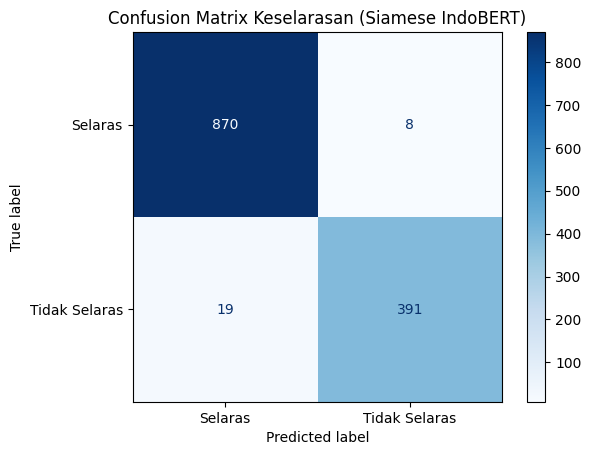

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = df["label"].map({
    1: "Selaras",
    0: "Tidak Selaras"
})

y_pred = df["pred_keselarasan"]

labels = ["Selaras", "Tidak Selaras"]

cm = confusion_matrix(y_true, y_pred, labels=labels)
print(classification_report(y_true, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_true, y_pred))

ConfusionMatrixDisplay(cm, display_labels=labels).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix Keselarasan (Siamese IndoBERT)")
plt.show()
